# Regression and Other Stories: Congress
Predictive uncertainty for congressional elections. See Chapters 10 and 15 in Regression and Other Stories.

In [67]:
import arviz as az
from bambi import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

In [13]:
import pymc3 as pm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import seaborn as sns

In [2]:
congress = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Congress/data/congress.csv")
inconsistent = ((congress["inc88"] ==-1) & (congress["v86"] > 0.5) |  ((congress["inc88"]==1) & (congress["v86"] < 0.5)))

congress.head()

,inc86,inc88,inc90,v86,v88,v90,v86_adj,v88_adj,v90_adj
0,1,1,1,0.745036,0.772443,0.714029,0.745036,0.772443,0.714029
1,1,1,1,0.673845,0.636182,0.597050,0.673845,0.636182,0.597050
2,1,1,0,0.696457,0.664928,0.521043,0.696457,0.664928,0.521043
3,-1,-1,-1,0.464590,0.273834,0.234377,0.464590,0.273834,0.234377
4,-1,-1,0,0.391095,0.263613,0.477439,0.391095,0.263613,0.477439


In [55]:
data88 = pd.DataFrame(dict(vote=congress["v88_adj"], past_vote=congress["v86_adj"], inc=congress["inc88"]))
data90 = pd.DataFrame(dict(vote=congress["v90_adj"], past_vote=congress["v88_adj"], inc=congress["inc90"]))
data88.head()

,vote,past_vote,inc
0,0.772443,0.745036,1
1,0.636182,0.673845,1
2,0.664928,0.696457,1
3,0.273834,0.464590,-1
4,0.263613,0.391095,-1


In [7]:
model = Model(data88)
fit88 = model.fit('vote ~ past_vote + inc', samples=1000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vote_sd, inc, past_vote, Intercept]
INFO:pymc3:NUTS: [vote_sd, inc, past_vote, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
/home/tommy/miniconda3/envs/stan/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


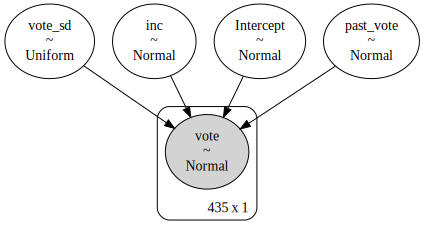

In [14]:
pm_model = model.backend.model
pm.model_to_graphviz(pm_model)

In [8]:
func_dict = {"Median": np.median,
            "MAD_SD":stats.median_abs_deviation,
             }
coefs = az.summary(fit88, stat_funcs=func_dict, extend=False, round_to=2)
coefs

,Median,MAD_SD
Intercept[0],0.24,0.01
past_vote[0],0.52,0.02
inc[0],0.10,0.00
vote_sd,0.07,0.00


In [36]:
coefs

,Median,MAD_SD
Intercept[0],0.24,0.01
past_vote[0],0.52,0.02
inc[0],0.10,0.00
vote_sd,0.07,0.00


In [38]:
a = coefs.loc["Intercept[0]", "Median"]
b_v = coefs.loc["past_vote[0]", "Median"]
b_i = coefs.loc["inc[0]", "Median"]
sd = coefs.loc["vote_sd", "Median"]

In [43]:
y_rep = a + b_v * vote_domain + (b_i*-1)
y_non = a + b_v * vote_domain + (b_i*0)
y_dem = a + b_v * vote_domain + (b_i*1)

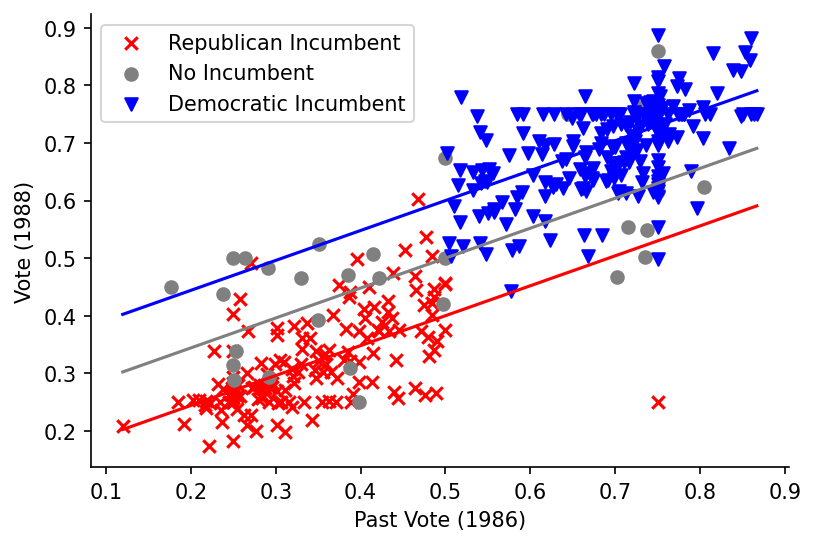

In [56]:
fig, ax = plt.subplots()

# # Generate x range
vote_domain = np.linspace(data88["past_vote"].min(), data88["past_vote"].max(), 100)

# # # Plot No HS Line
ax.plot(vote_domain, y_rep, c="red")
ax.plot(vote_domain, y_non, c="grey")
ax.plot(vote_domain, y_dem, c="b")

# Add scatter plot
markers = ["x", "o", "v"]
colors = ["r", "grey", "b"]
labels = ["Republican Incumbent", "No Incumbent", "Democratic Incumbent"]
for ix, incumbency in enumerate([-1, 0, 1]):
    data = data88.loc[data88["inc"] == incumbency]
    ax.scatter(
        data["past_vote"], data["vote"],
        marker=markers[ix],
        label=labels[ix],
        color=colors[ix],
    )

# data88.plot(kind="scatter", x="past_vote", y="vote", c=data88["inc"].replace({-1: "r", 1: "b", 0: "grey"}).values, ax=ax)
ax.legend()
ax.set_xlabel("Past Vote (1986)")
ax.set_ylabel("Vote (1988)")
sns.despine();

In [77]:
print(dir(model))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add', '_add_y', '_added_priors', '_backend_name', '_diagnostics', '_match_derived_terms', '_prepare_prior', '_set_backend', '_set_priors', 'add', 'added_terms', 'auto_scale', 'backend', 'build', 'built', 'clean_data', 'completes', 'data', 'default_priors', 'dm_statistics', 'dropna', 'family', 'fit', 'fixed_terms', 'noncentered', 'plot', 'plot_priors', 'random_terms', 'reset', 'set_priors', 'taylor', 'term_names', 'terms', 'y']


In [79]:
# model.backend.model

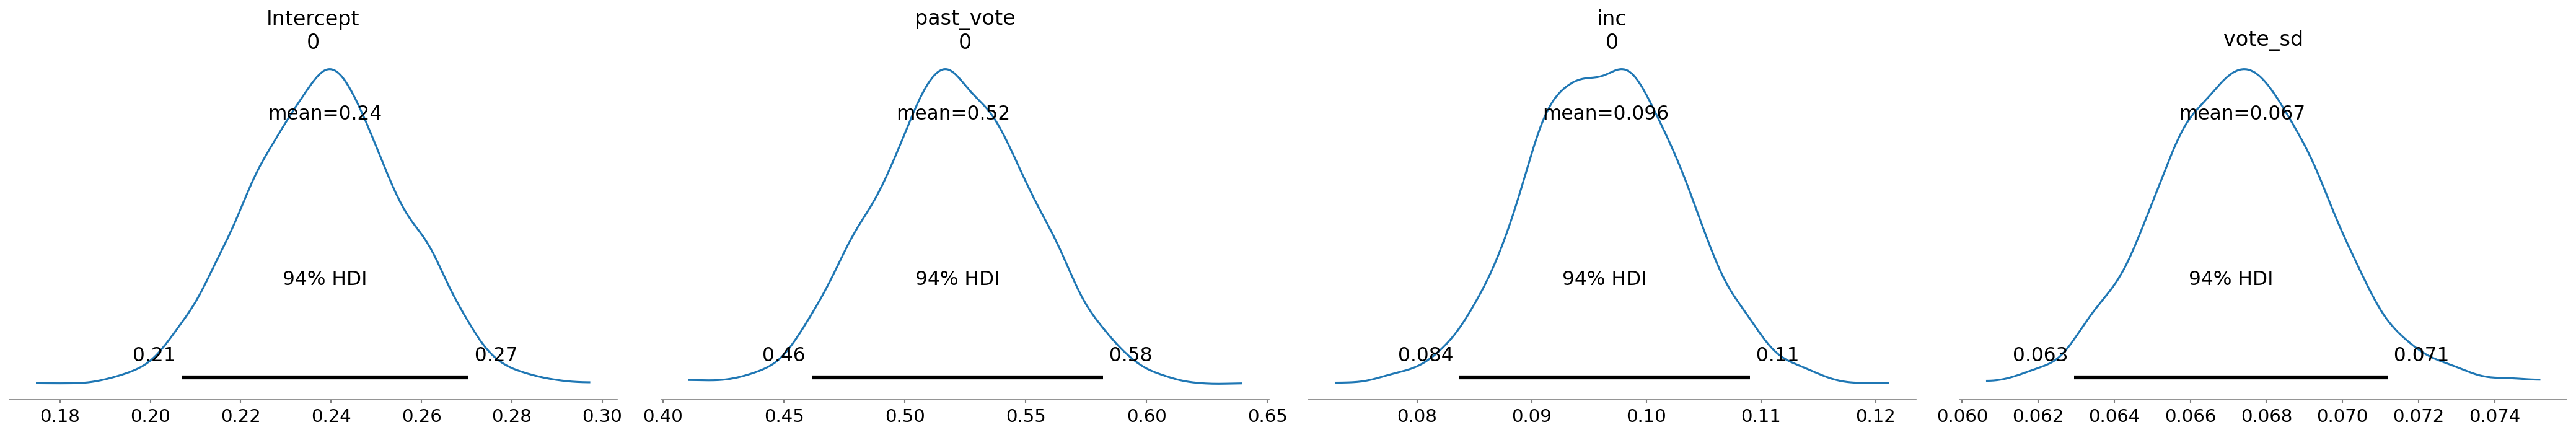

In [58]:
az.plot_posterior(fit88);

# Posterior predictive

In [101]:
pm_model = model.backend.model
RANDOM_SEED = 1

with pm_model:
    ppc = pm.sample_posterior_predictive(fit88, random_seed=RANDOM_SEED)
    ppc = az.from_pymc3(posterior_predictive=ppc)

In [102]:
posterior_check = ppc.posterior_predictive.isel(chain=0, vote_dim_1=0).to_dataframe().reset_index("draw").drop(["chain", "vote_dim_1"], axis=1)

In [103]:
posterior_check.head()

,draw,vote
vote_dim_0,,
0,0,0.824091
1,0,0.642758
2,0,0.660466
3,0,0.324828
4,0,0.407942


<AxesSubplot:xlabel='vote'>

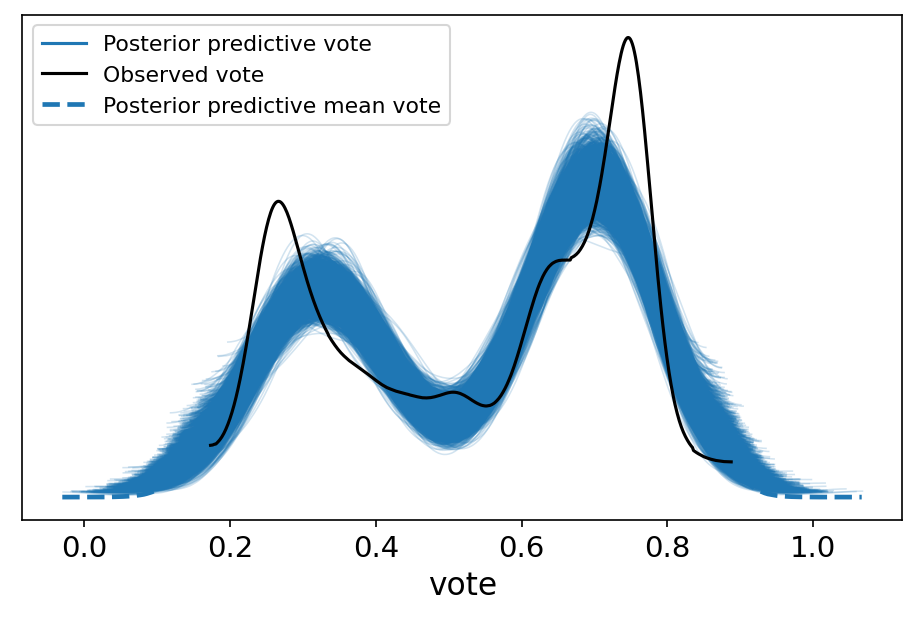

In [104]:
az.plot_ppc(ppc);

In [105]:
?az.plot_ppc

Signature:
az.plot_ppc(
    data,
    kind='kde',
    alpha=None,
    mean=True,
    color='C0',
    figsize=None,
    textsize=None,
    data_pairs=None,
    var_names=None,
    filter_vars=None,
    coords=None,
    flatten=None,
    flatten_pp=None,
    num_pp_samples=None,
    random_seed=None,
    jitter=None,
    animated=False,
    animation_kwargs=None,
    legend=True,
    ax=None,
    backend=None,
    backend_kwargs=None,
    group='posterior',
    show=None,
)
Docstring:
Plot for posterior/prior predictive checks.

Parameters
----------
data: az.InferenceData object
    InferenceData object containing the observed and posterior/prior predictive data.
kind: str
    Type of plot to display (kde, cumulative, or scatter). Defaults to kde.
alpha: float
    Opacity of posterior/prior predictive density curves.
    Defaults to 0.2 for kind = kde and cumulative, for scatter defaults to 0.7
mean: bool
    Whether or not to plot the mean posterior/prior predictive distribution. Defau

In [76]:
# pm.plot_posterior_predictive_glm?

In [9]:
# TODO: Rest of this notebook
# Figure out how to run posterior predictive simulations in bambi